## Data Preprocessing


In [108]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation

# Functions


In [109]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def apply_threshold(image, threshold):
    h,w=image.shape
    for i in range (h):
        for j in range (w):
            image[i][j]=image[i][j]>threshold
    return image

In [157]:
def preprocess_image(image_path):
    image = io.imread(image_path)
    gray_image= (rgb2gray(image[:,:,0:3])*255).astype(np.uint8)
    binary_img=apply_threshold(gray_image,threshold_otsu(gray_image))

    # erosion_img=binary_erosion(binary_img)
    binary_erosion_img= np.where(binary_img, 255, 0)
    binary_img_np = np.array(binary_erosion_img, dtype=np.uint8)


    contours, _ = cv2.findContours(binary_img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    paper_corners = cv2.approxPolyDP(contour, epsilon, True)
    if len(paper_corners) == 4:
        # Proceed with perspective transformation
        paper_corners = paper_corners.reshape(4, 2).astype("float32")
    else:
        raise ValueError("Couldn't detect a quadrilateral from the contour.")
    #print(paper_corners)
    width_top = np.linalg.norm(paper_corners[0] - paper_corners[1])  # Top edge
    width_bottom = np.linalg.norm(paper_corners[2] - paper_corners[3])  # Bottom edge
    height_left = np.linalg.norm(paper_corners[0] - paper_corners[3])  # Left edge
    height_right = np.linalg.norm(paper_corners[1] - paper_corners[2])  # Right edge

    # Average the dimensions to get a more accurate width and height
    width = int(max(width_top, width_bottom))  # Use max or mean if desired
    height = int(max(height_left, height_right))
    # if width > height:
    #     width, height = height, width
    print(width,height)
    dst_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(paper_corners, dst_points)

    # Apply the warp
    warped_image = cv2.warpPerspective(binary_img_np, M, (width, height))
    if(width>height):
        rotated_image = cv2.rotate(warped_image, cv2.ROTATE_90_CLOCKWISE)
        final_img = cv2.flip(rotated_image, 1)
    else:
        final_img = cv2.flip(warped_image, 1)
    return final_img

2060 2882


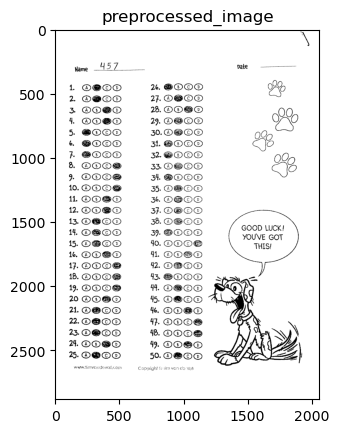

In [167]:
#./Data set/bubble sheet/1/1.jpg
preprocessed_image=preprocess_image("./Data set/bubble sheet/6.jpg")
show_images([preprocessed_image],["preprocessed_image"])